# HW#2 Kaggle Challenge

In this homework, you will train a model to predict back order.

However, the dataset is highly imbalanced.

You will need to deal with this problem and train a model to achieve the best performance.

In [1]:
import pandas as pd
import numpy as np

## Load Dataset

We will use the Pandas library for loading `csv` files into `DataFrame`, which is a 2-dimension table.

In [2]:
import pandas as pd

In [3]:
train_data = pd.read_csv("./train_data.csv")
train_data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,went_on_backorder
0,3520988,8.0,8.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,...,0.0,0.99,0.99,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1357206,18.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.86,0.84,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2,1857911,1089.0,8.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,...,0.0,0.50,0.66,0.0,0.0,0.0,1.0,1.0,0.0,0.0
3,3455231,70.0,8.0,2.0,42.0,88.0,123.0,11.0,45.0,95.0,...,1.0,0.70,0.71,0.0,0.0,0.0,1.0,1.0,0.0,0.0
4,1316436,57.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.96,0.96,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [4]:
test_data = pd.read_csv("./test_data.csv")
test_data.head()

,sku,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,...,potential_issue,pieces_past_due,perf_6_month_avg,perf_12_month_avg,local_bo_qty,deck_risk,oe_constraint,ppap_risk,stop_auto_buy,rev_stop
0,3384866,18.0,9.0,10.0,0.0,0.0,0.0,33.0,39.0,53.0,...,0.0,0.0,0.94,0.83,0.0,0.0,0.0,0.0,1.0,0.0
1,3029666,770.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.07,0.21,0.0,0.0,0.0,0.0,1.0,0.0
2,3188469,881.0,9.0,0.0,0.0,0.0,0.0,5.0,19.0,39.0,...,0.0,0.0,0.85,0.82,4.0,0.0,0.0,0.0,1.0,0.0
3,2149770,1.0,8.0,0.0,8.0,8.0,8.0,1.0,2.0,5.0,...,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,1.0,0.0
4,1853225,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.62,0.77,0.0,1.0,0.0,0.0,1.0,0.0


## Train a simple Logistic Regression model

I will use the `LogisticRegression` model from `sklearn` library.

For more information about the model, please refer to the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.linear_model.LogisticRegression.html).

In [108]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score, accuracy_score, f1_score, classification_report, roc_curve, auc, precision_score, recall_score
from sklearn.model_selection import StratifiedKFold

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler

import matplotlib.pyplot as plt

In [109]:
train_X = train_data.drop(columns=["sku", "went_on_backorder"])
y = train_data["went_on_backorder"]

train_X["inv_to_sales_1m"] = train_X["national_inv"] / (train_X["sales_1_month"] + 1)
train_X["inv_to_forecast_3m"] = train_X["national_inv"] / (train_X["forecast_3_month"] + 1)
train_X["sales_ratio_1_3"] = train_X["sales_1_month"] / (train_X["sales_3_month"] + 1)
train_X["sales_ratio_3_6"] = train_X["sales_3_month"] / (train_X["sales_6_month"] + 1)
train_X["risk_score"] = train_X[['deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']].sum(axis=1)
train_X["adjusted_lead_time"] = train_X["lead_time"] / (train_X["perf_6_month_avg"] + 0.01)

train_X.head()

,national_inv,lead_time,in_transit_qty,forecast_3_month,forecast_6_month,forecast_9_month,sales_1_month,sales_3_month,sales_6_month,sales_9_month,...,oe_constraint,ppap_risk,stop_auto_buy,rev_stop,inv_to_sales_1m,inv_to_forecast_3m,sales_ratio_1_3,sales_ratio_3_6,risk_score,adjusted_lead_time
0,8.0,8.0,0.0,0.0,0.0,0.0,0.0,3.0,11.0,13.0,...,0.0,0.0,1.0,0.0,8.000000,8.000000,0.00000,0.25000,2.0,8.000000
1,18.0,9.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,18.000000,18.000000,0.00000,0.00000,1.0,10.344828
2,1089.0,8.0,0.0,0.0,0.0,0.0,1.0,3.0,5.0,9.0,...,0.0,1.0,1.0,0.0,544.500000,1089.000000,0.25000,0.50000,2.0,15.686275
3,70.0,8.0,2.0,42.0,88.0,123.0,11.0,45.0,95.0,157.0,...,0.0,1.0,1.0,0.0,5.833333,1.627907,0.23913,0.46875,2.0,11.267606
4,57.0,8.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,1.0,0.0,57.000000,57.000000,0.00000,0.00000,1.0,8.247423


In [110]:
scaler = StandardScaler()
train_X_scaled = scaler.fit_transform(train_X)

In [114]:
smote = SMOTE(random_state=42)
train_X_res, y_res = smote.fit_resample(train_X_scaled, y)

In [112]:
thresholds = [0.4, 0.5, 0.6]
kfold = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
results = []

for threshold in thresholds:
    f1s, precisions, recalls, accs, aucs = [], [], [], [], []

    for train_idx, val_idx in kfold.split(train_X_res, y_res):
        X_train, X_val = train_X_res[train_idx], train_X_res[val_idx]
        y_train, y_val = y_res.iloc[train_idx], y_res.iloc[val_idx]

        model = LogisticRegression(class_weight='balanced', solver='saga', max_iter=500)
        model.fit(X_train, y_train)

        probs = model.predict_proba(X_val)[:, 1]
        preds = (probs >= threshold).astype(int)

        f1s.append(f1_score(y_val, preds))
        precisions.append(precision_score(y_val, preds))
        recalls.append(recall_score(y_val, preds))
        accs.append(accuracy_score(y_val, preds))
        aucs.append(roc_auc_score(y_val, probs))

    results.append({
        "threshold": threshold,
        "f1": np.mean(f1s),
        "precision": np.mean(precisions),
        "recall": np.mean(recalls),
        "accuracy": np.mean(accs),
        "roc_auc": np.mean(aucs)
    })

results_df = pd.DataFrame(results)
print(results_df)

/Users/seoyeongkim/Desktop/SKKU/2025-1/기계학습원론/SWE3050-Fundamentals-of-Machine-Learning/HW2/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/seoyeongkim/Desktop/SKKU/2025-1/기계학습원론/SWE3050-Fundamentals-of-Machine-Learning/HW2/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/seoyeongkim/Desktop/SKKU/2025-1/기계학습원론/SWE3050-Fundamentals-of-Machine-Learning/HW2/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/Users/seoyeongkim/Desktop/SKKU/2025-1/기계학습원론/SWE3050-Fundamentals-of-Machine-Learning/HW2/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: T

   threshold        f1  precision    recall  accuracy   roc_auc
0        0.4  0.714756   0.627258  0.830622  0.668517  0.745720
1        0.5  0.689708   0.659321  0.723044  0.674717  0.745717
2        0.6  0.611339   0.723041  0.529533  0.663350  0.745717


/Users/seoyeongkim/Desktop/SKKU/2025-1/기계학습원론/SWE3050-Fundamentals-of-Machine-Learning/HW2/venv/lib/python3.13/site-packages/sklearn/linear_model/_sag.py:348: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(


In [115]:
clf = LogisticRegression(class_weight="balanced", max_iter=3000, solver="liblinear")
clf.fit(train_X_res, y_res)

LogisticRegression(class_weight='balanced', max_iter=3000, solver='liblinear')

In [116]:
probs = clf.predict_proba(train_X_res)[:, 1]

threshold = 0.5
pred_custom = (probs >= threshold).astype(int)

F1 score:  0.7355901092313487
ROC AUC:  0.805047782654321


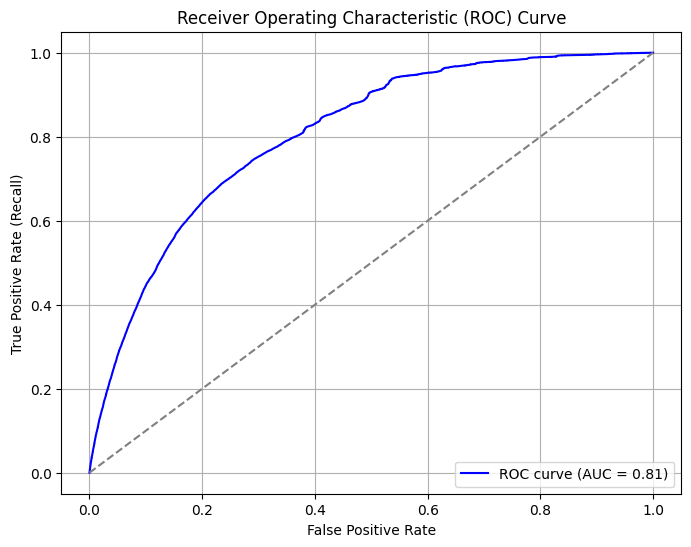

Accuracy score:  0.7231055555555556
              precision    recall  f1-score   support

         0.0       0.75      0.68      0.71     90000
         1.0       0.70      0.77      0.74     90000

    accuracy                           0.72    180000
   macro avg       0.73      0.72      0.72    180000
weighted avg       0.73      0.72      0.72    180000



In [117]:
print("F1 score: ", f1_score(y_res, pred_custom))
print("ROC AUC: ", roc_auc_score(y_res, probs))
# ROC Curve용 값
fpr, tpr, thresholds = roc_curve(y_res, probs)
roc_auc = auc(fpr, tpr)

# 그래프
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='blue', label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='gray', linestyle='--')  # 랜덤 모델 기준선
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate (Recall)')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()
print("Accuracy score: ", accuracy_score(y_res, pred_custom))
print(classification_report(y_res, pred_custom))

In [118]:
test_X = test_data.drop(columns=["sku"])

test_X["inv_to_sales_1m"] = test_X["national_inv"] / (test_X["sales_1_month"] + 1)
test_X["inv_to_forecast_3m"] = test_X["national_inv"] / (test_X["forecast_3_month"] + 1)
test_X["sales_ratio_1_3"] = test_X["sales_1_month"] / (test_X["sales_3_month"] + 1)
test_X["sales_ratio_3_6"] = test_X["sales_3_month"] / (test_X["sales_6_month"] + 1)
test_X["risk_score"] = test_X[['deck_risk', 'oe_constraint', 'ppap_risk', 'stop_auto_buy', 'rev_stop']].sum(axis=1)
test_X["adjusted_lead_time"] = test_X["lead_time"] / (test_X["perf_6_month_avg"] + 0.01)

In [119]:
test_X_scaled = scaler.transform(test_X)

In [120]:
probs_test = clf.predict_proba(test_X_scaled)[:, 1]

threshold = 0.5
pred_test = (probs_test >= threshold).astype(int)

In [121]:
predictions = clf.predict_proba(test_X)

/Users/seoyeongkim/Desktop/SKKU/2025-1/기계학습원론/SWE3050-Fundamentals-of-Machine-Learning/HW2/venv/lib/python3.13/site-packages/sklearn/utils/validation.py:2732: UserWarning: X has feature names, but LogisticRegression was fitted without feature names
  warnings.warn(


### Make predictions on the test data

The evaluation is done on Kaggle, so we need to make predictions on the test data and submit the predictions to Kaggle.

The file format should be as follows:
```
Index,Class
0,0.0
1,0.0
2,1.0
...
```

In [122]:
submission = pd.DataFrame({"ID": range(len(test_data)), "Class": pred_test})
submission.head(5)

,ID,Class
0,0,1
1,1,0
2,2,0
3,3,1
4,4,0


In [123]:
submission.to_csv("submission_liblinear.csv", index=False)

## Some tips

You can also use the LogisticRegression Code implemented directly in problem 1.

There are many ways to improve the model performance (e.g. feature engineering, hyperparameter tuning, etc.). You can try different methods to improve your model performance.

Also, you could try various methods to deal with the imbalanced dataset problem (e.g. oversampling, undersampling, class weight, etc.).

If you have any questions regarding the homework, feel free to ask on the anonymous bulletin board.

Good luck!